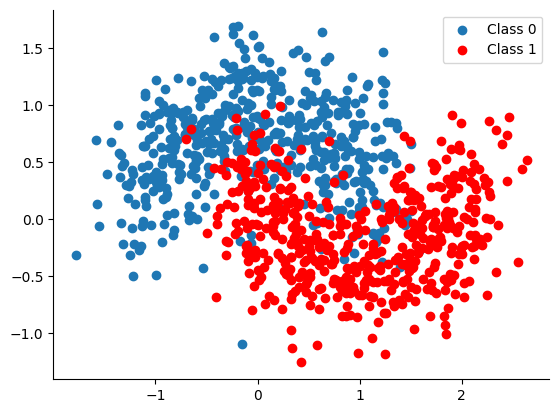

In [2]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt 
import seaborn as sns

X, Y = make_moons(noise=0.3, n_samples=1000)
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], label="Class 0")
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1")
sns.despine()
plt.legend();

In [3]:
import mxnet as mx
from mxnet import nd, autograd, gluon,np,npx

n_groups = 18

n_grps_sq = int(np.sqrt(n_groups))
n_samples = 100

objc[25167]: Class CaptureDelegate is implemented in both /opt/homebrew/Cellar/opencv/4.6.0/lib/libopencv_videoio.4.6.0.dylib (0x13fce0860) and /Users/sergio/opt/miniconda3/envs/mxnet/lib/libopencv_videoio.4.6.0.dylib (0x2901e1240). One of the two will be used. Which one is undefined.


In [4]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])

    X = X.dot(R)

    return np.asarray(X)

In [5]:
np.random.seed(31)

Xs, Ys = [], []
for i in range(n_groups):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)

    # Rotate the points randomly for each category
    rotate_by = np.random.randn() * 90.0
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(np.asarray(Y))

[19:52:57] /Users/sergio/code/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


In [6]:
np.stack(Ys,axis=0).shape

(18, 100)

In [7]:
Xs = np.stack(Xs,axis=0)
Ys = np.stack(Ys,axis=0)

Xs_train = Xs[:, : n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2 :, :]
Ys_train = Ys[:, : n_samples // 2]
Ys_test = Ys[:, n_samples // 2 :]

In [8]:
import sys
sys.path.append("../") 
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax
from mxnet import npx 
import mxnet.gluon.probability as mxp 
from mxnet.gluon import nn

model_ctx=mx.cpu()
hyper={'alpha':1.0}

class NN(nn.HybridBlock):

    def __init__(self):
        super().__init__()
        self.dense1 = nn.Dense(5,activation='tanh')
        self.dense2 = nn.Dense(5,activation='relu')
        self.dense3 = nn.Dense(2)
    
    def forward(self, x):
        layer1 = self.dense1(x)
        layer2 = self.dense2(layer1)
        layer3 = self.dense3(layer2)
        return layer3

    
def negative_log_prior(net,**args):
    par=net.collect_params()
    for k,v in args.items():
        if k=='y_train':
            y=v
        if k=='alpha':
            alpha=v
    param_prior=mxp.normal.Normal(loc=0.,scale=alpha)
    log_prior=list()
    for var in par.keys():
        for p in par[var].list_data():
            if p.ctx==y.ctx:
                log_prior.append(np.sum(param_prior.log_prob(p)))
    return -np.sum(np.stack(log_prior))
    
def negative_log_likelihood(net,**args):
    for k,v in args.items():
        if k=='y_train':
            y=v
        if k=='output':
            y_linear=v
    prob=npx.softmax(y_linear)
    y_hat=mxp.Categorical(num_events=1,prob=prob)
    return -np.sum(y_hat.log_prob(y))
        
def loss(par,net,**args):
    log_like=negative_log_likelihood(net,**args)
    log_prior=negative_log_prior(net,**args)
    return log_like+log_prior

In [9]:
model=NN()
model.initialize()
model(np.ones([1,2]))
inference=sgd(model,step_size=0.1,ctx=model_ctx)

In [10]:
from mxnet.gluon.metric import Accuracy

batch_size=20
epochs=1500
metric=Accuracy()

dataset = mx.gluon.data.dataset.ArrayDataset(Xs_train[0,:], Ys_train[0,:])
train_data = mx.gluon.data.DataLoader(dataset, batch_size=batch_size)

n_batches=len(train_data)
params=model.collect_params()
momentum={var:mx.np.zeros_like(params[var].data()) for var in params.keys()}
trainer = gluon.Trainer(params, 'sgd', {'learning_rate': 0.1})
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()
loss_val=list()
for i in range(epochs):
    cumulative_loss=0.0
    for j,(X_batch, y_batch) in enumerate(train_data):
        X_batch=X_batch.as_in_context(model_ctx)
        y_batch=y_batch.as_in_context(model_ctx)
        with autograd.record():
            outputs = model(X_batch)
            #curr_loss = loss_fn(outputs, y_batch).sum()
            curr_loss=loss(params,model,y_train=y_batch,output=outputs,alpha=1.0)
        curr_loss.backward()#calculo de derivadas parciales de la funcion segun sus parametros. por retropropagacion
        #trainer.step(batch_size)
        cumulative_loss+=curr_loss.asnumpy()
        inference.step(momentum,params)
        metric.update(labels=[y_batch],preds=[outputs])    
        metric_name,train_accuracy=metric.get()
    loss_val.append(cumulative_loss/Xs.shape[0])
    if i % (epochs //10) == 0:
        print('iteration {0}, train loss: {1:.4f}, train {2} : {3:.4f}'.format(i,loss_val[-1],metric_name,train_accuracy))
        

iteration 0, train loss: 10.7202, train accuracy : 0.5200
iteration 150, train loss: 10.2976, train accuracy : 0.7944
iteration 300, train loss: 10.2974, train accuracy : 0.7972
iteration 450, train loss: 10.2980, train accuracy : 0.7981
iteration 600, train loss: 10.2980, train accuracy : 0.7986
iteration 750, train loss: 10.2980, train accuracy : 0.7989
iteration 900, train loss: 10.2980, train accuracy : 0.7991
iteration 1050, train loss: 10.2980, train accuracy : 0.7992
iteration 1200, train loss: 10.2980, train accuracy : 0.7993
iteration 1350, train loss: 10.2980, train accuracy : 0.7994


In [62]:
from mxnet.gluon import Parameter
from mxnet.gluon.nn import Activation

class Centered_Layer(nn.HybridBlock):

    def __init__(self, units, in_units, **kwargs):
        super().__init__(**kwargs)
        self.mu = Parameter('mu', shape=(in_units, units))
        self.std = Parameter('std', shape=(in_units, units))

    def forward(self, x):
        eps=np.random.normal(loc=0, scale=1, size=self.mu.shape, ctx=x.ctx)
        z=self.mu.data(ctx=x.ctx)+np.exp(0.5*self.std.data(ctx=x.ctx))*eps
        act = np.dot(x, z)
        return npx.relu(act)

In [74]:
class Centered_NN(nn.HybridBlock):

    def __init__(self):
        super().__init__()
        self.centered_dense1 = Centered_Layer(units=5, in_units=2)
        self.centered_dense2 = Centered_Layer(units=5, in_units=5)
        self.dense3 = nn.Dense(2)
    
    def forward(self, x):
        layer1 = self.centered_dense1(x)
        layer2 = self.centered_dense2(layer1)
        layer3 = self.dense3(layer2)
        return layer3

In [93]:
centered_model=Centered_NN()
centered_model.initialize()


In [96]:
batch_size=20
epochs=1500
metric=Accuracy()

dataset = mx.gluon.data.dataset.ArrayDataset(Xs_train[0,:], Ys_train[0,:])
train_data = mx.gluon.data.DataLoader(dataset, batch_size=batch_size)

n_batches=len(train_data)
params=centered_model.collect_params()
momentum={var:mx.np.zeros_like(params[var].data()) for var in params.keys()}
trainer = gluon.Trainer(params, 'sgd', {'learning_rate': 0.1})
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()
loss_val=list()
for i in range(epochs):
    cumulative_loss=0.0
    for j,(X_batch, y_batch) in enumerate(train_data):
        X_batch=X_batch.as_in_context(model_ctx)
        y_batch=y_batch.as_in_context(model_ctx)
        with autograd.record():
            outputs = centered_model(X_batch)
            #curr_loss = loss_fn(outputs, y_batch).sum()
            curr_loss=loss(params,centered_model,y_train=y_batch,output=outputs,alpha=1.0)
        curr_loss.backward()#calculo de derivadas parciales de la funcion segun sus parametros. por retropropagacion
        #trainer.step(batch_size)
        cumulative_loss+=curr_loss.asnumpy()
        inference.step(momentum,params)
        metric.update(labels=[y_batch],preds=[outputs])    
        metric_name,train_accuracy=metric.get()
    loss_val.append(cumulative_loss/Xs.shape[0])
    if i % (epochs //10) == 0:
        print('iteration {0}, train loss: {1:.4f}, train {2} : {3:.4f}'.format(i,loss_val[-1],metric_name,train_accuracy))
        

iteration 0, train loss: 15.0641, train accuracy : 0.5000
iteration 150, train loss: 14.9241, train accuracy : 0.5066
iteration 300, train loss: 14.4880, train accuracy : 0.5555
iteration 450, train loss: 14.3846, train accuracy : 0.5540
iteration 600, train loss: 14.4425, train accuracy : 0.5565
iteration 750, train loss: 14.4966, train accuracy : 0.5632
iteration 900, train loss: 14.1770, train accuracy : 0.5688
iteration 1050, train loss: 15.1572, train accuracy : 0.5715
iteration 1200, train loss: 14.7431, train accuracy : 0.5751
iteration 1350, train loss: 14.6653, train accuracy : 0.5740
